In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("backtests").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

backtests/btest000.pickle


In [3]:
from backtest import DataParser, MovingWindow
import numpy as np


fsize = 32
tfdict = {"M5":0, "M15":1, "H1":2}
X, y, poslist = [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[2:]:
        f, _ = mw(pos.open_indx)
        x = build_features(f, 
                           pos.dir, 
                           btest.cfg.stops_processor.func.cfg.sl, 
                           btest.cfg.trailing_stop_rate,
                           pos.open_date, 
                           tfdict[btest.cfg.period])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(f"{X[0, 0, -2, 0]:8.0f} -> {X[-1, 0, -2, 0]:8.0f}")

BTCUSD 510
(508, 1, 9, 32) (508,)
20180522 -> 20231010


(381, 1, 7, 32) (127, 1, 7, 32) (127,)
35.122887


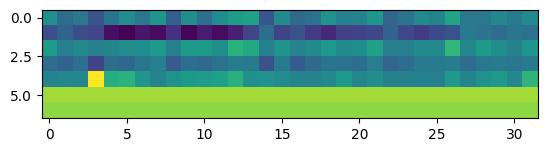

In [4]:
X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y)
print(X_train.shape, X_test.shape, tf_test.shape)
plt.imshow(X_train[0][0][:])
print(profs_test.sum())

In [24]:
X_test[0]

array([[[ 2.06649780e-01, -9.42916870e-02, -1.14097595e-01,
          1.37069702e-01, -7.56988525e-02, -1.91993713e-01,
          1.06063843e-01, -2.22282410e-01, -7.70263672e-02,
         -6.87637329e-02,  1.04293823e-02,  3.96270752e-02,
          4.03251648e-01, -3.92295837e-01,  2.02331543e-01,
         -2.93121338e-02,  3.66317749e-01,  2.56881714e-02,
          7.16949463e-01,  8.72314453e-01, -2.75337219e-01,
          8.58993530e-02, -2.01278687e-01,  2.49801636e-01,
         -2.64503479e-01,  2.27317810e-01, -3.48358154e-02,
         -3.07502747e-01,  2.08091736e-01,  1.73950195e-02,
          0.00000000e+00,  2.28080750e-01],
        [-1.72665405e+00, -1.52357483e+00, -1.61643982e+00,
         -1.72869110e+00, -1.59399414e+00, -1.66848755e+00,
         -1.85727692e+00, -1.75318909e+00, -1.97157288e+00,
         -2.04708099e+00, -2.11444092e+00, -2.10423279e+00,
         -2.06545258e+00, -1.67052460e+00, -2.05627441e+00,
         -1.85809326e+00, -1.88686371e+00, -1.52745056e+

[001,    30] loss train: 0.6724 | test: 0.0233
[002,    30] loss train: 0.6746 | test: 0.0227
[003,    30] loss train: 0.6656 | test: 0.0228
[004,    30] loss train: 0.6624 | test: 0.0225
[005,    30] loss train: 0.6646 | test: 0.0223
[006,    30] loss train: 0.6610 | test: 0.0229
[007,    30] loss train: 0.6581 | test: 0.0229
[008,    30] loss train: 0.6514 | test: 0.0224
[009,    30] loss train: 0.6572 | test: 0.0223
[010,    30] loss train: 0.6539 | test: 0.0226
[011,    30] loss train: 0.6511 | test: 0.0226
[012,    30] loss train: 0.6502 | test: 0.0231
[013,    30] loss train: 0.6487 | test: 0.0224
[014,    30] loss train: 0.6424 | test: 0.0225
[015,    30] loss train: 0.6412 | test: 0.0228
[016,    30] loss train: 0.6358 | test: 0.0225
[017,    30] loss train: 0.6303 | test: 0.0237
[018,    30] loss train: 0.6324 | test: 0.0224
[019,    30] loss train: 0.6272 | test: 0.0226
[020,    30] loss train: 0.6179 | test: 0.0237
000 mae_train: 0.42
000 profit M5 :   +0.0 ->    +0.0 --
000

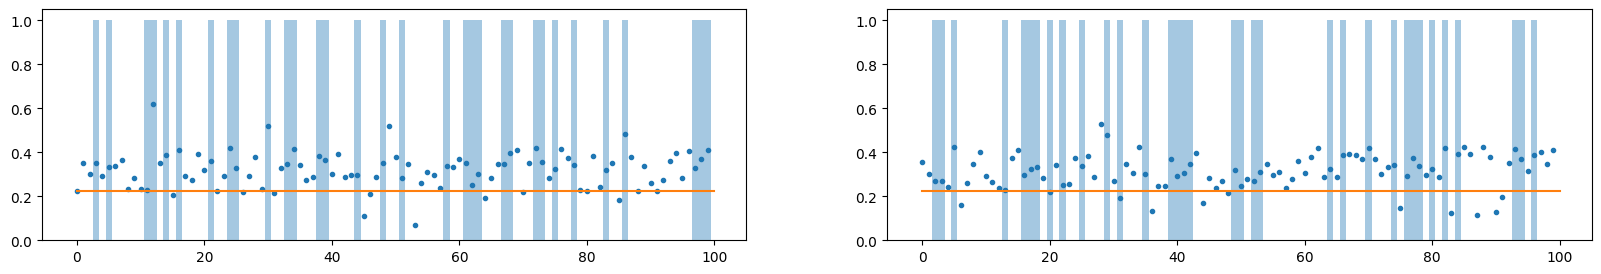

In [5]:
from sklearn.metrics import mean_absolute_error, f1_score
import torch
device = "cuda"

nitrers = 1
test_split_size = 0.2
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    # np.random.seed(i)
    X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y, test_split_size)
    model = train(X_train, y_train, X_test, y_test, batch_size=56)
    model.eval()
    
    p_train = model(torch.tensor(X_train).float().to(device)).detach().cpu().numpy().squeeze()
    p_test = model(torch.tensor(X_test).float().to(device)).detach().cpu().numpy().squeeze()
    metrics[0, i] = mean_absolute_error(p_train, y_train)
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f}")
    if test_split_size > 0:
        metrics[1, i] = mean_absolute_error(p_test, y_test)
        # profsum_best, threshold = 0, None
        # for th in np.arange(-4, 0, 0.25):
        #     profsum = (profs_test*(p_test>th)).sum()
        #     if profsum > profsum_best:
        #         profsum_best = profsum
        #         threshold = th
        threshold = np.percentile(p_train, 10)
        for j in range(3):
            ids = tf_test == j
            pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
            gprofits[j, i] = profs_test[ids].sum()
            print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
        print(f"{i:03} mae_test: {metrics[1, i]:4.2f}")
        
        pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
        gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)
        f1_mean = metrics.mean(axis=1, where=metrics!=0)
        pprofs_mean_tot = np.nanmean(pprofs_mean)
        gprofs_mean_tot = np.nanmean(gprofs_mean)
        print("-------------------------------------------------")
        print(gprofs_mean, " -> ", pprofs_mean)
        print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ratio: {f1_mean[1]/f1_mean[0]:4.2f}")
        print(f"av. profit boost: {(pprofs_mean_tot - gprofs_mean_tot)/abs(gprofs_mean_tot)}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100, 0], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    plt.subplot(1, 2, 2)
    plt.plot(p_test[:100], ".")
    plt.bar(np.arange(100), y_test[:100, 0], width=[1]*100, alpha=0.4)
    # plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
    plt.plot([0, 100], [threshold, threshold])
    
model.set_threshold(threshold)
torch.save(model.state_dict(), "model.pth")

In [7]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model.forward_thresholded(torch.tensor(X_test).float().to(device)).squeeze()
profs_test.sum(), (profs_test*p_test).sum()

(354.4391, 449.07678)

In [8]:
list(model.named_parameters())[0]

('threshold',
 Parameter containing:
 tensor([0.2238], device='cuda:0'))

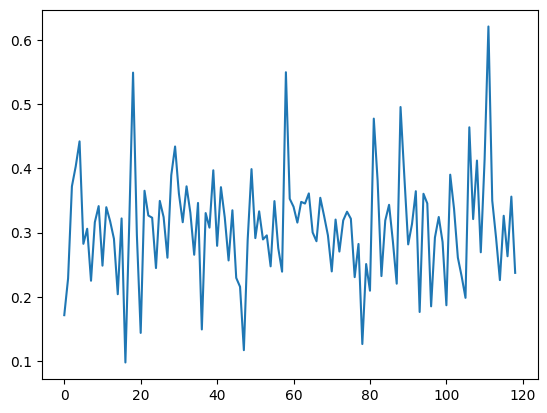

In [17]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [9]:
threshold

0.22376672327518463

In [10]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(776, 1876, 2091, 2091)

In [11]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

FileNotFoundError: data/bitfinex/H1

In [ ]:
prediction

array([[0.49287947, 0.50712053]])